In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import optuna
from optuna.samplers import TPESampler
import pickle
import warnings
from google.colab import files

warnings.filterwarnings('ignore')


In [ ]:
FEATURE_COLS = [
    'Electrical speed [rad/s]',
    'I_M_a', 'I_M_b', 'I_M_c',
    'I_P_a', 'I_P_b', 'I_P_c',
    'I_B_a', 'I_B_b', 'I_B_c',
    'V_M_a', 'V_M_b', 'V_M_c',
    'V_P_a', 'V_P_b', 'V_P_c',
    'V_B_a', 'V_B_b', 'V_B_c'
]
LABEL_COL = 'Class label'

def optimize_svm(X, y, n_trials=50, name=""):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    def objective(trial):
        C = trial.suggest_float('C', 1e-1, 1e4, log=True)
        gamma = trial.suggest_float('gamma', 1e-4, 1e1, log=True)
        svc = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced')
        return cross_val_score(svc, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    C_opt = study.best_params['C']
    gamma_opt = study.best_params['gamma']
    print(f"  Best: C={C_opt:.4f}, gamma={gamma_opt:.6f}, CV={study.best_value:.4f}")
    return C_opt, gamma_opt

In [ ]:
uploaded = files.upload()
file1 = list(uploaded.keys())[0]
df1 = pd.read_csv(file1)
X_all = df1[FEATURE_COLS].values
y_all = df1[LABEL_COL].values
for c in sorted(np.unique(y_all)):
    print(f"  Class {c:2d} : {np.sum(y_all == c):4d} samples")

Saving data_exp8.csv to data_exp8 (2).csv
  Class  1 :   45 samples
  Class  2 :  446 samples
  Class  3 :  450 samples
  Class  4 :  455 samples
  Class  5 :  450 samples
  Class  6 :  450 samples
  Class  7 :  450 samples
  Class  8 :  450 samples
  Class  9 :  450 samples
  Class 10 :  450 samples
  Class 11 :  450 samples
  Class 12 :  450 samples
  Class 13 :  450 samples
  Class 14 :  450 samples
  Class 15 :  450 samples
  Class 16 :  450 samples


In [ ]:
KNOWN_CLASSES = [1, 2, 3, 4, 5, 6, 7, 8]
NEW_CLASSES   = [9, 10, 11, 12, 13, 14, 15, 16]

mask_known = np.isin(y_all, KNOWN_CLASSES)
mask_new   = np.isin(y_all, NEW_CLASSES)

X_known = X_all[mask_known]
y_known = y_all[mask_known]
X_new = X_all[mask_new]
y_new = y_all[mask_new]

X_known_train, X_known_test, y_known_train, y_known_test = train_test_split(
    X_known, y_known, test_size=0.2, stratify=y_known, random_state=42
)
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    X_new, y_new, test_size=0.2, stratify=y_new, random_state=42
)

X_test_all = np.vstack([X_known_test, X_new_test])
y_test_all = np.hstack([y_known_test, y_new_test])

print(f"\nKnown - Train: {len(y_known_train)}, Test: {len(y_known_test)}")
print(f"New   - Train: {len(y_new_train)},   Test: {len(y_new_test)}")
print(f"Test total:    {len(y_test_all)}")

Classes known  : [1, 2, 3, 4, 5, 6, 7, 8]
Classes unknown: [9, 10, 11, 12, 13, 14, 15, 16]

Known - Train: 2556, Test: 640
New   - Train: 2880,   Test: 720
Test total:    1360


In [ ]:
scaler = StandardScaler()
X_known_train_sc = scaler.fit_transform(X_known_train)
X_new_train_sc = scaler.transform(X_new_train)
X_test_all_sc = scaler.transform(X_test_all)

ALL_CLASSES = np.array(sorted(KNOWN_CLASSES + NEW_CLASSES))


Scaler fitted, 16 classes totales


In [ ]:
#for known fault 1-8
C1, gamma1 = optimize_svm(X_known_train_sc, y_known_train, n_trials=50, name="E1")

expert1 = SVC(C=C1, gamma=gamma1, kernel='rbf',
              class_weight='balanced', probability=True, random_state=42)
expert1.fit(X_known_train_sc, y_known_train)

acc1_train = accuracy_score(y_known_train, expert1.predict(X_known_train_sc))
n_sv1 = len(expert1.support_)

y_pred_e1 = expert1.predict(X_test_all_sc)
acc_e1 = accuracy_score(y_test_all, y_pred_e1)


Optimisation Optuna — Expert 1 (classes 1-8)
  Données: 2556 samples, 8 classes


  0%|          | 0/50 [00:00<?, ?it/s]

  Best: C=9554.7273, gamma=0.926345, CV=0.9926

EXPERT 1
  C=9554.7273, gamma=0.926345
  Accuracy (train): 1.0000
  Support Vectors:  888
  Classes:          [1, 2, 3, 4, 5, 6, 7, 8]

  Test accuracy (E1 sur 16 classes): 0.4706
  (E1 ne connaît que 1-8 → classes 9-16 toutes fausses)


In [ ]:
#new faults : extraction of SV of E1
X_sv1 = X_known_train_sc[expert1.support_]
y_sv1 = y_known_train[expert1.support_]

for c in sorted(np.unique(y_sv1)):
    print(f"  Class {c:2d}: {np.sum(y_sv1 == c)} SVs")

# SV_E1 U new data
X_e2_data = np.vstack([X_sv1, X_new_train_sc])
y_e2_data = np.hstack([y_sv1, y_new_train])

  Class  1: 19 SVs
  Class  2: 155 SVs
  Class  3: 156 SVs
  Class  4: 160 SVs
  Class  5: 78 SVs
  Class  6: 88 SVs
  Class  7: 85 SVs
  Class  8: 147 SVs


In [ ]:
C2, gamma2 = optimize_svm(X_e2_data, y_e2_data, n_trials=50, name="E2)")

expert2 = SVC(C=C2, gamma=gamma2, kernel='rbf',
              class_weight='balanced', probability=True, random_state=42)
expert2.fit(X_e2_data, y_e2_data)

acc2_train = accuracy_score(y_e2_data, expert2.predict(X_e2_data))
n_sv2 = len(expert2.support_)

# Test E2
y_pred_e2 = expert2.predict(X_test_all_sc)
acc_e2 = accuracy_score(y_test_all, y_pred_e2)
print(f"\n  Test accuracy : {acc_e2:.4f}")


Optimisation Optuna — Expert 2 (SVs + 9-16)
  Données: 3768 samples, 16 classes


  0%|          | 0/50 [00:00<?, ?it/s]

  Best: C=9849.7606, gamma=0.483488, CV=0.8976

EXPERT 2 (SV Transfer)
  C=9849.7606, gamma=0.483488
  Accuracy (train): 0.9687
  Support Vectors:  1643
  Classes:          [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]

  Test accuracy (E2 sur 16 classes): 0.9684
  Amélioration E1→E2: 0.4706 → 0.9684 (+49.8%)


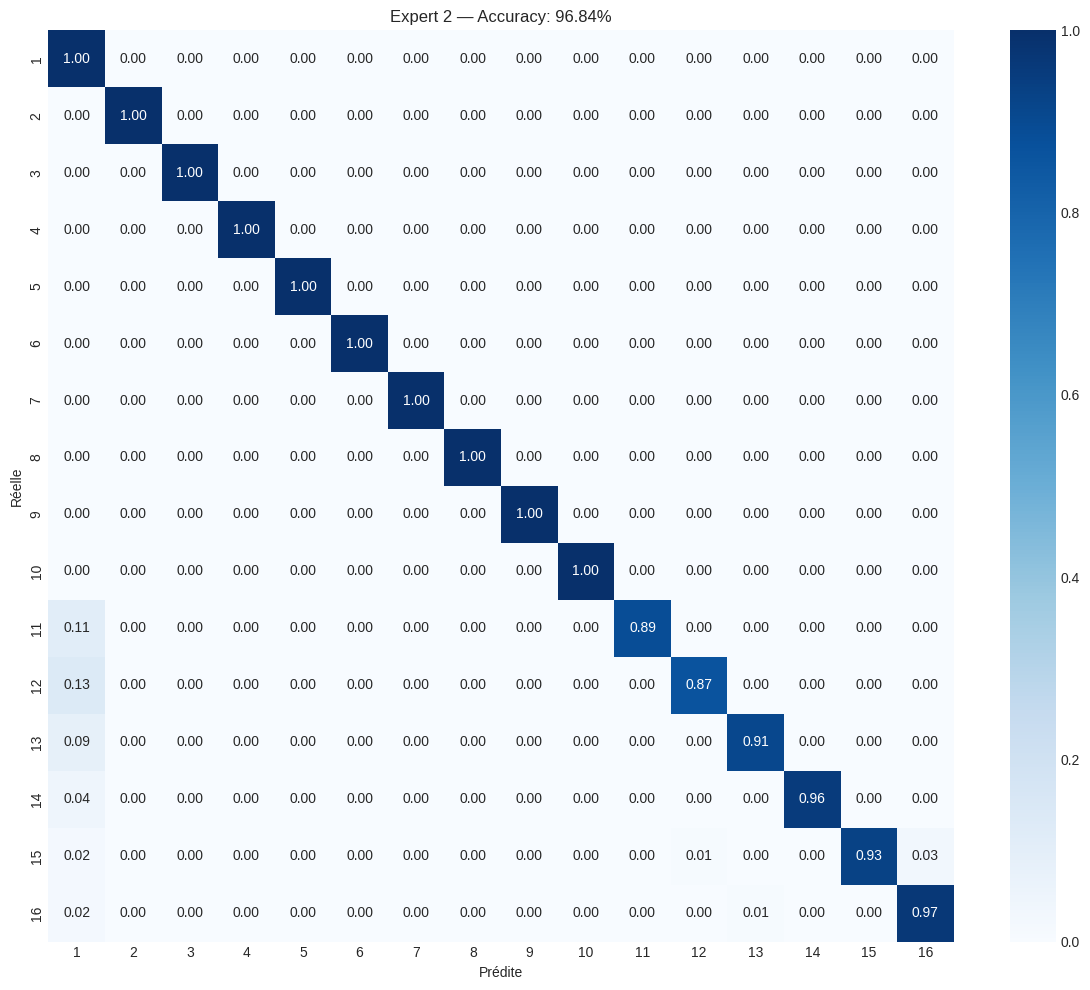

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

cm = confusion_matrix(y_test_all, y_pred_e2, labels=ALL_CLASSES)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=ALL_CLASSES.astype(int),
            yticklabels=ALL_CLASSES.astype(int),
            ax=ax, vmin=0, vmax=1)

ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"E2 — Accuracy: {acc_e2:.2%}")
plt.tight_layout()
plt.show()

In [ ]:
#all knowwn fault
uploaded = files.upload()
file2 = list(uploaded.keys())[0]
df2 = pd.read_csv(file2)
X_file2 = df2[FEATURE_COLS].values
y_file2 = df2[LABEL_COL].values

X_file2_sc = scaler.transform(X_file2)

Saving data_exp9.csv to data_exp9.csv
Chargé: 5305 échantillons, 16 classes
Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]


In [ ]:
# Sv_e2
X_sv2 = X_e2_data[expert2.support_]
y_sv2 = y_e2_data[expert2.support_]

# Sv_E2 U new data
X_e3_data = np.vstack([X_sv2, X_file2_sc])
y_e3_data = np.hstack([y_sv2, y_file2])

In [ ]:
#rafinement-test
C3, gamma3 = optimize_svm(X_e3_data, y_e3_data, n_trials=50, name="E3")

expert3 = SVC(C=C3, gamma=gamma3, kernel='rbf',
              class_weight='balanced', probability=True, random_state=42)
expert3.fit(X_e3_data, y_e3_data)

acc3_train = accuracy_score(y_e3_data, expert3.predict(X_e3_data))
n_sv3 = len(expert3.support_)

print(f"\nEXPERT 3 (raffinement)")
print(f"  C={C3:.4f}, gamma={gamma3:.6f}")
print(f"  Accuracy (train): {acc3_train:.4f}")
print(f"  Support Vectors:  {n_sv3}")
print(f"  Classes:          {sorted(np.unique(y_e3_data))}")


Optimisation Optuna — Expert 3 (SVs + Fichier2)
  Données: 6948 samples, 16 classes


  0%|          | 0/50 [00:00<?, ?it/s]

  Best: C=9970.9398, gamma=0.868983, CV=0.9306

EXPERT 3 (raffinement)
  C=9970.9398, gamma=0.868983
  Accuracy (train): 0.9668
  Support Vectors:  2504
  Classes:          [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]



  Test accuracy (E3 sur fichier 1): 0.9699


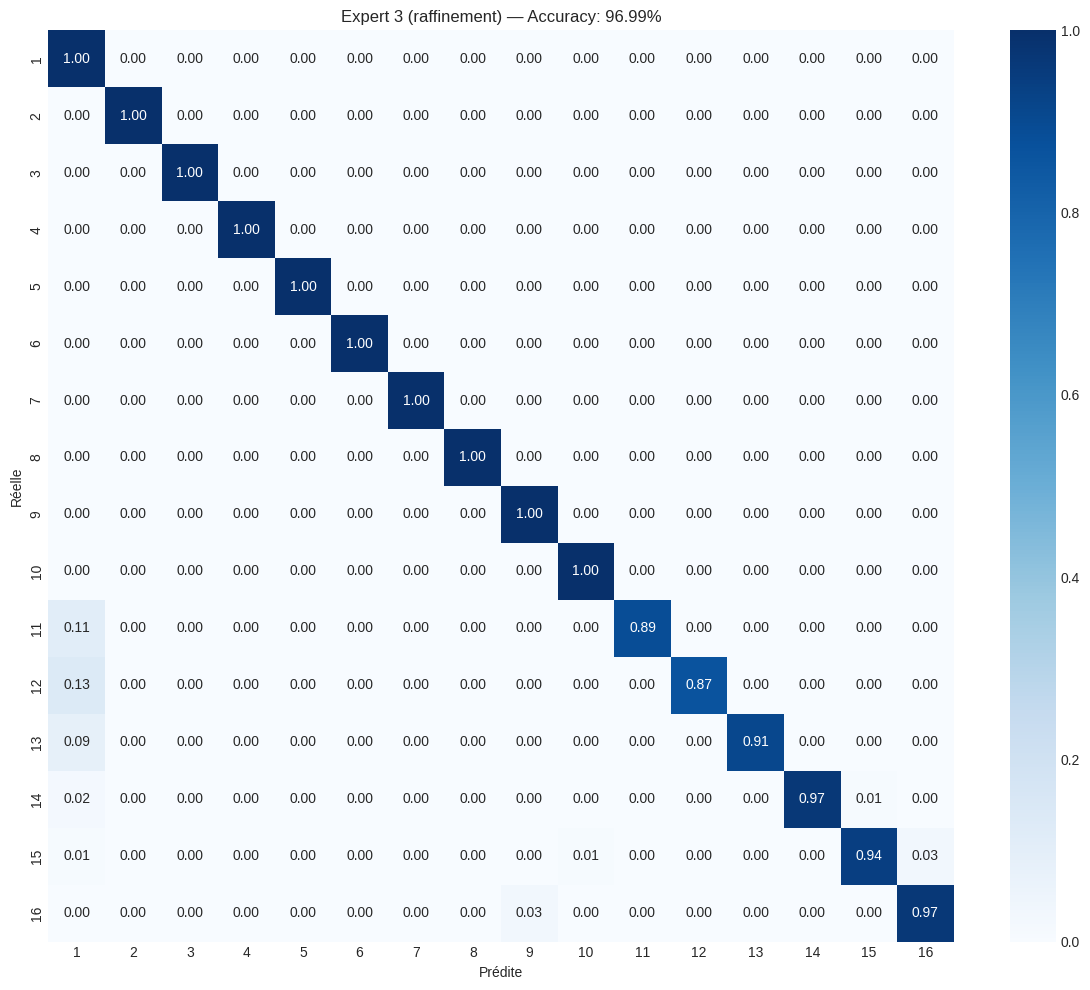

In [ ]:

y_pred_e3 = expert3.predict(X_test_all_sc)
acc_e3 = accuracy_score(y_test_all, y_pred_e3)
print(f"\n  Test accuracy (E3 sur fichier 1): {acc_e3:.4f}")

fig, ax = plt.subplots(figsize=(12, 10))

cm = confusion_matrix(y_test_all, y_pred_e3, labels=ALL_CLASSES)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=ALL_CLASSES.astype(int),
            yticklabels=ALL_CLASSES.astype(int),
            ax=ax, vmin=0, vmax=1)

ax.set_xlabel('Prédite')
ax.set_ylabel('Réelle')
ax.set_title(f"Expert 3 (raffinement) — Accuracy: {acc_e3:.2%}")
plt.tight_layout()
plt.show()

In [ ]:
best_model = {
    'clf': expert3,
    'scaler': scaler,
    'classes': sorted(np.unique(y_e3_data).tolist()),
    'accuracy_train': acc3_train,
    'accuracy_test': acc_e3_final,
    'C': C3,
    'gamma': gamma3,
    'method': 'SV Transfer (3 étapes)',
    'n_sv': n_sv3,
}

with open('learnpp_sv_transfer.pkl', 'wb') as f:
    pickle.dump(best_model, f)

files.download('learnpp_sv_transfer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>